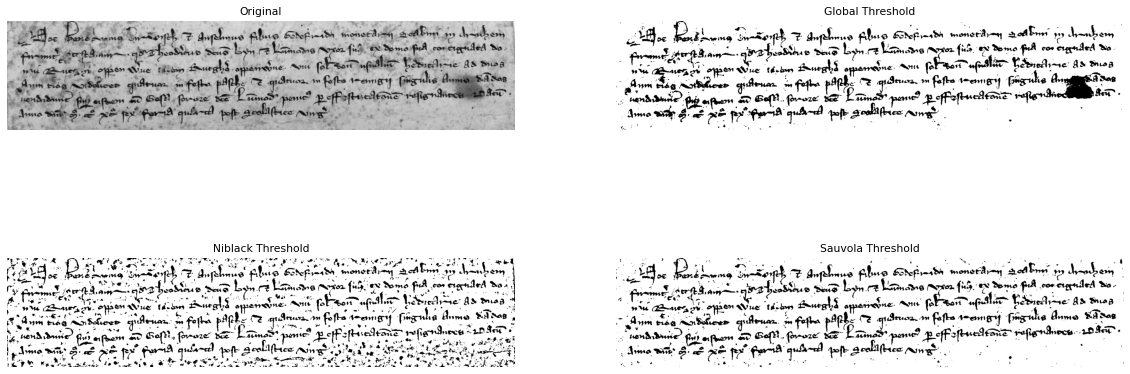

In [9]:
import matplotlib
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.filters import (threshold_otsu, threshold_niblack, threshold_sauvola)

matplotlib.rcParams['font.size'] = 9

# Load the image
image = io.imread('dev_images/ali_lmalki.ppm')
# image = color.rgb2gray(image)

# Apply global thresholding
binary_global = image > threshold_otsu(image)

# Apply Niblack thresholding
window_size = 25
k = 0.8
thresh_niblack = threshold_niblack(image, window_size=window_size, k=k)
binary_niblack = image > thresh_niblack

# Apply Sauvola thresholding
window_size = 25
thresh_sauvola = threshold_sauvola(image, window_size=window_size)
binary_sauvola = image > thresh_sauvola

# Display the results
plt.figure(figsize=(20, 8))
plt.subplot(2, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Global Threshold')
plt.imshow(binary_global, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(binary_niblack, cmap=plt.cm.gray)
plt.title('Niblack Threshold')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(binary_sauvola, cmap=plt.cm.gray)
plt.title('Sauvola Threshold')
plt.axis('off')

plt.show()

In [11]:
closed = binary_sauvola

# Skeletonization


/var/folders/h7/2fzz3h9j1r95q9xkh46gr8z40000gn/T/ipykernel_4987/1594781350.py:7: UserWarning: skeleton.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave('skeleton.png', invert(skeleton))


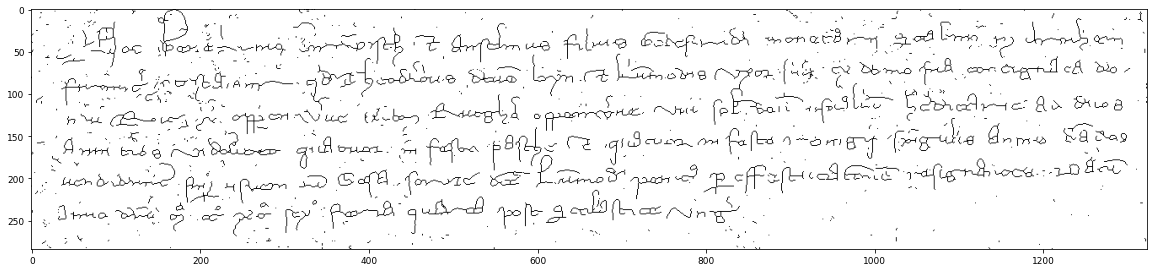

In [12]:
from skimage.util import invert
from skimage.morphology import skeletonize

inverted_image = invert(closed)
skeleton = skeletonize(inverted_image)
# write the skeleton image to disk
io.imsave('skeleton.png', invert(skeleton))

#skeleton = invert(skeleton)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(invert(skeleton), cmap='gray')
plt.show()

# Getting forkpoints


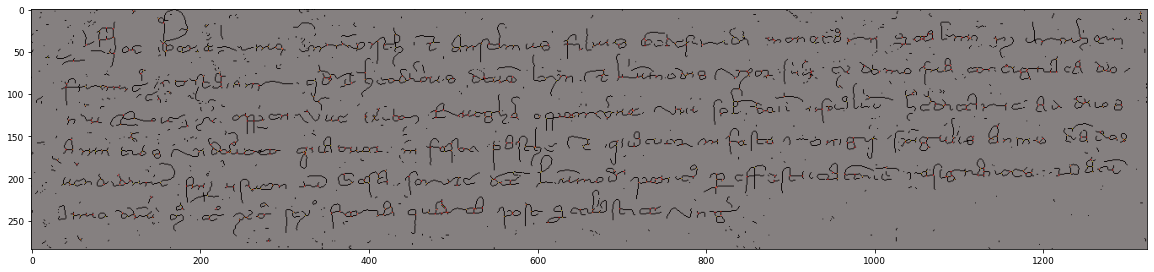

In [13]:
import numpy as np
import scipy.ndimage as ndi
selems = list()
selems.append(np.array([[0, 1, 0], [1, 1, 1], [0, 0, 0]]))
selems.append(np.array([[1, 0, 1], [0, 1, 0], [1, 0, 0]]))
selems.append(np.array([[1, 0, 1], [0, 1, 0], [0, 1, 0]]))
selems.append(np.array([[0, 1, 0], [1, 1, 0], [0, 0, 1]]))
selems.append(np.array([[0, 0, 1], [1, 1, 1], [0, 1, 0]]))
selems = [np.rot90(selems[i], k=j) for i in range(5) for j in range(4)]

selems.append(np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]]))
selems.append(np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]]))

forkpoints = np.zeros_like(skeleton, dtype=bool)
for selem in selems:
    forkpoints |= ndi.binary_hit_or_miss(skeleton, selem)
# display the skeleton and the forkpoints on top of it in some very bright color
fig, ax = plt.subplots(figsize=(20, 20))

ax.imshow(invert(skeleton), cmap='gray')
ax.imshow(forkpoints, cmap='hot', alpha=0.5)
plt.show()


# Getting endpoints


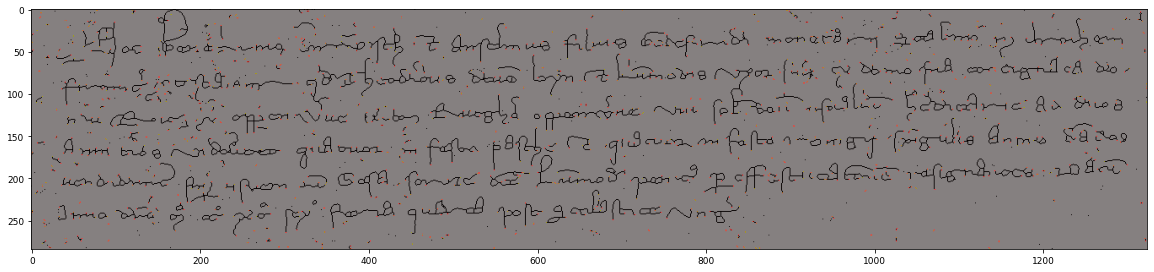

In [14]:
selems = list()
selems.append(np.array([[0, 1, 0], [0, 1, 0], [0, 0, 0]]))
selems.append(np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]]))
selems = [np.rot90(selems[i], k=j) for i in range(2) for j in range(4)]
endpoints = np.zeros_like(skeleton, dtype=bool)
for selem in selems:
    endpoints |= ndi.binary_hit_or_miss(skeleton, selem)

# display the skeleton and the endpoints on top of it in some very bright color
fig, ax = plt.subplots(figsize=(20, 20))

ax.imshow(invert(skeleton), cmap='gray')
ax.imshow(endpoints, cmap='hot', alpha=0.5)
plt.show()


# Getting contour of skeleton


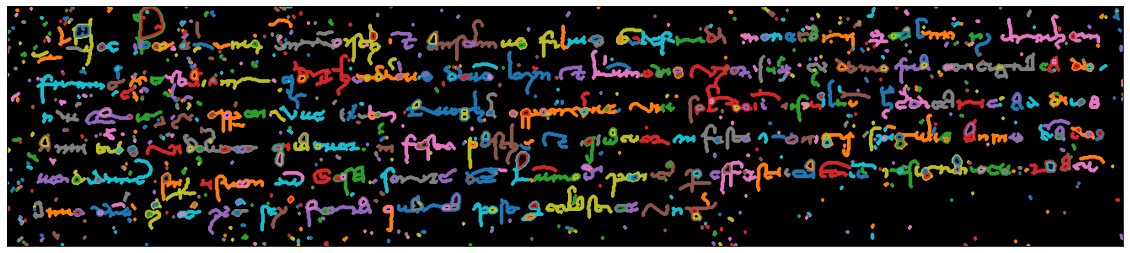

In [15]:
from skimage import measure
from skimage import img_as_ubyte
img = img_as_ubyte(skeleton)
contours = measure.find_contours(img, 0.5, 'high')

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(img, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Getting connected components


In [16]:
# setting minimum lengths for fragments
e = 3
min_frag_size = 2*e+2

In [17]:
import cv2
def skimage_to_opencv(skeleton):
    """Converts a skeleton image from skimage to opencv format."""
    return (skeleton * 255).astype(np.uint8)

def opencv_connected_components(skeleton):
    """Computes connected components using opencv."""
    ret, labels = cv2.connectedComponents(skeleton)
    return labels

def extract_fragments(skeleton, labels):
    """Extracts fragments from a skeleton image and its labels."""
    fragments = [ [] for _ in range(np.max(labels))]
    
    for y in range(skeleton.shape[0]):
        for x in range(skeleton.shape[1]):
            if skeleton[y, x]:
                label = labels[y, x] - 1
                fragments[label].append((y, x))
    return [fragment for fragment in fragments if fragment if len(fragment) > min_frag_size]

In [18]:
open_cv_skeleton = skimage_to_opencv(skeleton)
labels = opencv_connected_components(open_cv_skeleton)
fragments = extract_fragments(skeleton, labels)

### fragments


In [19]:
for fragment in fragments:
    #print(fragment)
    continue

### anti-clockwise fragments


### finding high curvature points


In [20]:
def comp_partial_max(I, from_, to):
    pmax = np.zeros_like(I)
    best = to

    pmax[to] = I[to]

    while to > from_:
        to -= 1
        if I[to] <= I[best]:
            pmax[to] = I[best]
        else:
            pmax[to] = I[to]
            best = to

    return best, pmax

def nms1d_cir(J, n):
    lenJ = len(J)
    lenI = lenJ + 3 * n
    I = np.zeros(lenI, dtype=float)
    MaximumAt = np.zeros(lenI, dtype=float)
    pmax = np.zeros(lenI, dtype=float)
    MAXIMUMAT = np.zeros(lenJ, dtype=float)
    n = min(lenJ, n)
    for j in range(n):
        #print("I[j]",I[j])
        #print("J[lenJ - n + j]",J[lenJ - n + j])

        I[j] = J[lenJ - n + j]
    for j in range(n, n + lenJ):
        I[j] = J[j - n]
    for j in range(n + lenJ, 2*n + lenJ):
        I[j] = J[j - n - lenJ]
    for j in range(2*n + lenJ, lenI):
        I[j] = -100000.0

    i = n
    chkpt = -1
    _, comp_partial_max(I, 0, i)
    while i < lenI - 2 * n:
        j, pmax = comp_partial_max(I, i, i + n)
        k, pmax = comp_partial_max(I, i + n, j + n)

        if i == j or I[j] > I[k]:
            if (chkpt <= j - n or I[j] >= pmax[chkpt]) and (j == n + i or I[j] >= pmax[j - n]):
                MaximumAt[j] = I[j]
            if i < j:
                chkpt = i + n
            i = j + n + 1
        else:
            i = k
            chkpt = j + n
            while i < lenI - 2 * n:
                j, pmax = comp_partial_max(I, chkpt - 1, i + n)
                if I[i] > I[j]:
                    MaximumAt[i] = I[i]
                    i = i + n + 1
                    break
                else:
                    chkpt = i + n
                    i = j

    MAXIMUMAT[:] = MaximumAt[n:n + lenJ]

    return MAXIMUMAT


In [ ]:
MAX_INT = 100000000000000000000000000000000000000000000000000000

In [21]:
from random import randint

def checkboundary(x, y, width, height):
    """Checks if the coordinates are within the boundaries."""
    return 0 <= x < width and 0 <= y < height

def find_curvature_points(skept):
    '''h, w = skept.shape
    strokelist = []
    used = np.ones((h, w), dtype=bool)

    for y in range(h):
        for x in range(w):
            if skept[y][x] and used[y, x]:
                tmplist = [np.array([y, x])]
                used[y, x] = False
                endpoints = []

                nt = 0
                while nt < len(tmplist):
                    cy = tmplist[nt][0]
                    cx = tmplist[nt][1]

                    nCnt = 0

                    for sy in range(-1, 2):
                        for sx in range(-1, 2):
                            if checkboundary(cx + sx, cy + sy, w, h) and skept[cy + sy][cx + sx]:
                                nCnt += 1
                                if used[cy + sy, cx + sx]:
                                    tmplist.append(np.array([cx + sx, cy + sy]))
                                    used[cy + sy, cx + sx] = False

                    if nCnt == 2:
                        endpoints.append(np.array([cx, cy]))

                    if nCnt > 3:
                        print("There are still fork points exist!")

                    nt += 1

                size = len(tmplist)
                idx = randint(0, MAX_INT)

                if len(endpoints) == 0:
                    endpoints.append(tmplist[idx])
                    endpoints.append(tmplist[(idx + 1) % size - 1])

                strokelist.append(endpoints)

    used = np.ones((h, w), dtype=bool)

    for n in range(len(strokelist)):
        if len(strokelist[n]) != 2:
            print(f"the end points {len(strokelist[n])} should be 2!")

        end = strokelist[n][0]

        search = [end]
        used[end[0], end[1]] = False

        nt = 0
        while nt < len(search):
            cy = search[nt][0]
            cx = search[nt][1]

            wbreak = False

            for sy in range(-1, 2):
                for sx in range(-1, 2):
                    if (checkboundary(cx + sx, cy + sy, w, h) and
                            skept[cy + sy, cx + sx] and
                            used[cy + sy, cx + sx]):
                        p = np.array([cx + sx, cy + sy])
                        search.append(p)
                        used[cy + sy, cx + sx] = False
                        wbreak = True
                        break

                if wbreak:
                    break

            nt += 1

        strokelist[n] = search
    return strokelist'''
    h, w = skept.shape
    used = np.full(h*w, True)
    strokelist = []
    for y in range(h):
        for x in range(w):
            if skept[y][x] and used[y*w+x]:
                tmplist = [np.array([y, x])]
                used[y*w+x] = False
                endpoints = []
                ln = len(tmplist)
                nt = 0
                while nt < ln:
                    cy = tmplist[nt][0]
                    cx = tmplist[nt][1]
                    nCnt = 0
                    for sy in range(-1, 2):
                        for sx in range(-1, 2):
                            if checkboundary(cx + sx, cy + sy, w, h) and skept[cy + sy][cx + sx]:
                                nCnt += 1
                                if used[(cy + sy)*w+cx + sx]:
                                    tmplist.append(np.array([cy + sy, cx + sx]))
                                    ln += 1
                                    used[(cy + sy)*w+cx + sx] = False
                    if nCnt == 2:
                        endpoints.append(np.array([cy, cx]))
                    if nCnt > 3:
                        print("fork points exist!")
                    nt += 1
                size = len(tmplist)
                idx = randint(0, MAX_INT) % size + 2
                if idx >= size:
                    idx = size - 1
                elif idx < 0:
                    idx = 0
                if len(endpoints) == 0:
                    endpoints.append(tmplist[idx])
                    endpoints.append(tmplist[(idx + 1) % size - 1])
                strokelist.append(endpoints)
    used = np.full(h*w, True)
    print(strokelist)
    size = len(strokelist)
    n = 0
    result = []
    while n < size:
        if len(strokelist[n]) != 2:
            print(f"the end points {len(strokelist[n])} should be 2!")
        end = strokelist[n][0]
        search = [end]
        used[end[0]*w+end[1]] = False
        search_size = len(search)
        nt = 0
        while nt < search_size:
            cy = search[nt][0]
            cx = search[nt][1]
            wbreak = False
            for sy in range(-1, 2):
                for sx in range(-1, 2):
                    if (checkboundary(cx + sx, cy + sy, w, h) and
                            skept[cy + sy, cx + sx] and
                            used[(cy + sy)*w+cx + sx]):
                        p = np.array([cy + sy, cx + sx])
                        search.append(p)
                        search_size += 1
                        used[(cy + sy)*w+cx + sx] = False
                        wbreak = True
                        break
                if wbreak:
                    break
            nt += 1
        result.append(search)
        n += 1
    return result



In [ ]:
test = find_curvature_points(skeleton)

fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points exist!
fork points 

In [ ]:
def find_curviest(strokelist, para):
    print(strokelist)
    candidates = []
    #print(strokelist)
    PI2 = 2 * np.pi

    for n in range(len(strokelist)):
        skelist = strokelist[n]

        angle = []

        for t in range(len(skelist)):
            cy, cx = skelist[t]

            idp1 = t - para
            if idp1 < 0:
                idp1 = 0
            p1 = skelist[idp1]

            idp2 = t + para
            if idp2 > len(skelist) - 1:
                idp2 = len(skelist) - 1
            p2 = skelist[idp2]

            ang1 = np.arctan2(cy - p1[1], cx - p1[0])
            if ang1 < 0.0:
                ang1 += PI2

            ang2 = np.arctan2(cy - p2[1], cx - p2[0])
            if ang2 < 0.0:
                ang2 += PI2

            tang_ang = np.abs(ang1 - ang2)
            tang_ang = np.pi + min(tang_ang, PI2 - tang_ang)
            angle.append(tang_ang)
        peak = nms1d_cir(angle, 10)

        for t in range(1, len(peak) - 1):
            if peak[t] > 0:
                candidates.append(skelist[t])
    
    return candidates
    

## Trying some other way for solving this problem


In [22]:
from scipy.signal import argrelextrema, savgol_filter, find_peaks
import math
from scipy.ndimage import gaussian_filter, uniform_filter1d
pixel_to_p2_p3_map = {}  # Mapping data structure to store the pixel to p2 and p3 mapping
def get_adjacent_pixels(skeleton, point):
    h, w = skeleton.shape
    adjacent_pixels = []
    for sy in range(-1, 2):
        for sx in range(-1, 2):
            if 0<= point[0] + sy < h and 0 <= point[1]+sx < w and skeleton[point[0] + sy, point[1] + sx] and not (sy == 0 and sx == 0):
                adjacent_pixels.append([point[0] + sy, point[1] + sx])
    return sorted(adjacent_pixels)

def compute_window_size(array_length, min_array_length, max_array_length, min_window_size=2, max_window_size=50):
    # Linear scaling between min_window_size and max_window_size
    window_size = min_window_size + (max_window_size - min_window_size) * (array_length - min_array_length) / (max_array_length - min_array_length)
    return int(window_size)


def traverse(skeleton, point, visited, e, count=0):
    if e == count:
        return point
    adjacent_pixels = get_adjacent_pixels(skeleton, point)
    if len(adjacent_pixels) != 2:
        return point
    
    visited[tuple(point)] = True
    if not visited[tuple(adjacent_pixels[0])]:
        return traverse(skeleton, adjacent_pixels[0], visited, e, count+1)
    return traverse(skeleton, adjacent_pixels[1], visited, e, count+1)

def find_minima(angles, window_size=10):
    epsilon = 1e-10
    adjusted_angles = angles - np.arange(len(angles)) * epsilon
    
    min_angle_indices = []
    for i in range(0, len(angles) - window_size + 1, window_size):
        min_angle_index = i + np.argmin(adjusted_angles[i:i + window_size])
        if not min_angle_indices or min_angle_index - min_angle_indices[-1] > 1:
            min_angle_indices.append(min_angle_index)
    return np.array(min_angle_indices)

def compute_angle(point, p2, p3):
    angle1 = np.arctan2(point[0] - p2[0], point[1] - p2[1])
    if angle1 < 0.0:
        angle1 += 2 * np.pi
    angle2 = np.arctan2(point[0] - p3[0], point[1] - p3[1])
    if angle2 < 0.0:
        angle2 += 2 * np.pi
    angle = np.abs(angle1 - angle2)
    tang_angle = min(angle, 2 * np.pi - angle)
    return tang_angle

'''def find_threshold(data, window_size):
    threshold = np.zeros_like(data)
    half_window = window_size // 2

    for i in range(len(data)):
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)
        window_data = data[start:end]
        
        median = np.median(window_data)
        deviations = np.abs(window_data - median)
        mad = np.median(deviations)
        threshold_value = median - 2*mad  # Adjust this formula as needed

        threshold[start:end] = threshold_value

    return threshold'''

def plot_high_curvature_points_angles(high_curvature_points_angles):
    plt.figure(figsize=(10, 10))
    plt.plot(range(len(high_curvature_points_angles)), high_curvature_points_angles, linestyle='-')
    plt.xlabel("Index")
    plt.ylabel("Angle (radians)")
    plt.title("High Curvature Points Angles")
    plt.ylim(0, 3 * np.pi)
    plt.show()
    
def extract_angles_minima(skeleton, fragments, e):
    smallest_fragment = min(fragments, key=len)
    largest_fragment = max(fragments, key=len)
    minima = []
    for fragment in fragments:
        candidates = []
        #print("Fragment:", fragment)
        for index, point in enumerate(fragment):
            # check if the point is either a branch point or an end point
            visited = np.zeros_like(skeleton)
            visited[tuple(point)] = True
            
            adjacent_pixels = get_adjacent_pixels(skeleton, point)
            #print("Adjacent pixels for point {}: {}".format(point, adjacent_pixels))
            if len(adjacent_pixels) != 2:
                candidates.append(2*np.pi)
                continue
            direction_point, opposite_point = adjacent_pixels
            p2 = traverse(skeleton, direction_point, visited, e)
            p3 = traverse(skeleton, opposite_point, visited, e)
            # Add the point, p2, and p3 to the mapping data structure
            pixel_to_p2_p3_map[tuple(point)] = (tuple(p2), tuple(p3))
            tang_angle = compute_angle(point, p2, p3)
            
            #print("Tangent angle for point {}: {}".format(point, tang_angle))
            candidates.append(tang_angle)
        #plot_high_curvature_points_angles(candidates)
        #candidates = gaussian_filter(candidates, sigma=1)
        #plot_high_curvature_points_angles(candidates)
        window_size = compute_window_size(len(fragment), len(smallest_fragment), len(largest_fragment))
        fragment_minima = find_minima(candidates, window_size=window_size)
        #fragment_minima = filter(candidates, fragment_minima, window_size=5)
        '''threshold = find_threshold(np.array(candidates), window_size=10) '''

        for index in fragment_minima:
            '''if candidates[index] <= threshold[index]:'''
            minima.append(fragment[index])
        #comparator = np.less
        #minima_indices = argrelextrema(np.array(candidates), comparator)
        '''# Print the indices of local minima
        print("Indices of local minima:", minima_indices)

        # Print the values of local minima
        print("Values of local minima:")
        for index in minima_indices[0]:
            print("Value of local minima:", candidates[index])'''
        '''threshold = np.mean(np.array([candidates[index] for index in minima_indices[0]]))/2'''
        #for index in minima_indices[0]:
        #    minima.append(fragment[index])
        #    '''minima.append(fragment[index])'''''
    return minima

In [23]:
high_curv_angles = extract_angles_minima(skeleton, fragments, 7)

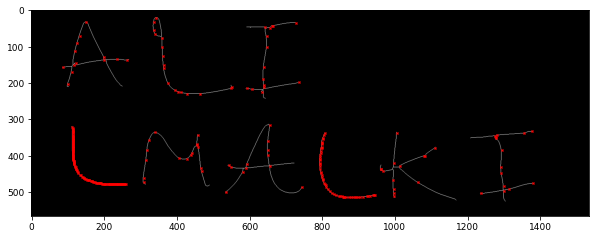

In [ ]:
'''# take all the high_curv_angles and plot them on the skeleton

def plot_skeleton_and_curvature_points(image, skeleton, high_curvature_points):
    plt.figure(figsize=(10, 10))
    plt.imshow(skeleton, cmap='gray')
    for fragment in high_curvature_points:
        for p in fragment:
            try:
                plt.plot(p[1], p[0], 'rx', markersize=2)
            except:
                print(p)
    try:
        plt.plot([p[1] for p in high_curvature_points], [p[0] for p in high_curvature_points], 'rx', label='High Curvature Points', markersize=2)
    except:
        print("")
    plt.show()


plot_skeleton_and_curvature_points(image, skeleton, high_curv_angles)
'''

## Store the curvy points


In [ ]:
'''from PIL import Image, ImageDraw
# get the skeleton image
img = Image.open('skeleton.png')
draw = ImageDraw.Draw(img)
print(high_curv_angles)
curvs = [(x,y) for y,x in high_curv_angles]

draw.point(curvs, fill='green')

img.save('curvature.png')
'''

[(20, 343), (32, 336), (54, 336), (64, 340), (75, 360), (100, 360), (125, 361), (150, 363), (160, 364), (199, 375), (212, 551), (215, 549), (220, 395), (224, 404), (226, 411), (229, 427), (229, 464), (32, 151), (71, 132), (91, 126), (111, 120), (127, 199), (134, 236), (137, 199), (137, 263), (146, 121), (151, 118), (157, 87), (171, 110), (202, 100), (34, 727), (42, 665), (43, 662), (47, 643), (48, 656), (71, 647), (101, 648), (155, 639), (189, 638), (198, 735), (206, 640), (210, 640), (214, 593), (217, 606), (224, 634), (316, 656), (359, 651), (385, 650), (399, 651), (422, 593), (426, 543), (428, 657), (431, 549), (434, 589), (446, 581), (487, 745), (500, 535), (320, 112), (323, 113), (326, 113), (328, 113), (331, 114), (334, 113), (336, 113), (338, 113), (342, 113), (344, 113), (346, 113), (348, 113), (350, 113), (352, 113), (354, 113), (356, 113), (358, 113), (360, 113), (362, 113), (364, 113), (366, 113), (368, 113), (370, 113), (372, 113), (374, 113), (376, 113), (378, 113), (380, 

In [ ]:
'''import os
from skimage.io import imsave
from skimage import img_as_ubyte
def save_fragments_with_curvature_points(skeleton, fragments, curvatures, output_dir='fragment_images'):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate over the fragments
    for idx, fragment in enumerate(fragments):
        # Create a blank image of the same shape as the skeleton
        fragment_image = np.zeros((*skeleton.shape, 3), dtype=np.uint8)

        # Set the pixels corresponding to the fragment to 255
        for point in fragment:
            fragment_image[point] = (255, 255, 255)

        for point in curvatures:
            print(point)
            if tuple(point) in fragment:
                fragment_image[point[0], point[1]] = (255, 0, 0)

        # Save the image as a PNG file
        output_path = os.path.join(output_dir, f'fragment_{idx}.png')
        imsave(output_path, img_as_ubyte(fragment_image))

# Save fragments with highest curvature points as images
save_fragments_with_curvature_points(skeleton, fragments, high_curv_angles)'''

"import os\nfrom skimage.io import imsave\nfrom skimage import img_as_ubyte\ndef save_fragments_with_curvature_points(skeleton, fragments, curvatures, output_dir='fragment_images'):\n    # Create output directory if it doesn't exist\n    if not os.path.exists(output_dir):\n        os.makedirs(output_dir)\n\n    # Iterate over the fragments\n    for idx, fragment in enumerate(fragments):\n        # Create a blank image of the same shape as the skeleton\n        fragment_image = np.zeros((*skeleton.shape, 3), dtype=np.uint8)\n\n        # Set the pixels corresponding to the fragment to 255\n        for point in fragment:\n            fragment_image[point] = (255, 255, 255)\n\n        for point in curvatures:\n            print(point)\n            if tuple(point) in fragment:\n                fragment_image[point[0], point[1]] = (255, 0, 0)\n\n        # Save the image as a PNG file\n        output_path = os.path.join(output_dir, f'fragment_{idx}.png')\n        imsave(output_path, img_as_ub

In [ ]:
'''import matplotlib.pyplot as plt
from matplotlib.patches import Arc
radius = 5
def plot_lines(image, point, p2, p3):
    angle = np.degrees(compute_angle(point, p2, p3))
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')

    plt.plot([point[1], p2[1]], [point[0], p2[0]], color='red', linewidth=1)
    plt.plot([point[1], p3[1]], [point[0], p3[0]], color='blue', linewidth=1)
    
    plt.scatter([point[1], p2[1], p3[1]], [point[0], p2[0], p3[0]], c=['green', 'red', 'blue'], marker='o')
    
    # Draw the angle using Arc
    #arc = Arc(point, 2 * radius, 2 * radius, 0, 0, angle, color='red')
    #plt.gca().add_patch(arc)
    angle_label = f"Angle: {angle:.2f}°"
    plt.plot([], [], label=angle_label)
    plt.legend()
    plt.axis('off')
    plt.show()
for fragment in fragments:
    for point in fragment:
        pixel = tuple(point)
        if pixel in pixel_to_p2_p3_map:
            p2, p3 = pixel_to_p2_p3_map[pixel]
            plot_lines(skeleton, pixel, p2, p3)'''

'import matplotlib.pyplot as plt\nfrom matplotlib.patches import Arc\nradius = 5\ndef plot_lines(image, point, p2, p3):\n    angle = np.degrees(compute_angle(point, p2, p3))\n    plt.figure(figsize=(10, 10))\n    plt.imshow(image, cmap=\'gray\')\n\n    plt.plot([point[1], p2[1]], [point[0], p2[0]], color=\'red\', linewidth=1)\n    plt.plot([point[1], p3[1]], [point[0], p3[0]], color=\'blue\', linewidth=1)\n    \n    plt.scatter([point[1], p2[1], p3[1]], [point[0], p2[0], p3[0]], c=[\'green\', \'red\', \'blue\'], marker=\'o\')\n    \n    # Draw the angle using Arc\n    #arc = Arc(point, 2 * radius, 2 * radius, 0, 0, angle, color=\'red\')\n    #plt.gca().add_patch(arc)\n    angle_label = f"Angle: {angle:.2f}°"\n    plt.plot([], [], label=angle_label)\n    plt.legend()\n    plt.axis(\'off\')\n    plt.show()\nfor fragment in fragments:\n    for point in fragment:\n        pixel = tuple(point)\n        if pixel in pixel_to_p2_p3_map:\n            p2, p3 = pixel_to_p2_p3_map[pixel]\n        

# getting the PSD


In [24]:
# the keypoints are the local minima and the forkpoints
print(forkpoints)
forkpoints = np.argwhere(forkpoints)

print(forkpoints)
keypoints = np.concatenate((forkpoints, np.array(high_curv_angles)))

keypoints = np.unique(keypoints, axis=0)
print(keypoints)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[   2  121]
 [   4 1316]
 [   6 1316]
 ...
 [ 252  613]
 [ 272   58]
 [ 274  281]]
[[   2  121]
 [   4 1316]
 [   5 1315]
 ...
 [ 274  280]
 [ 274  281]
 [ 274  282]]


In [25]:
from collections import defaultdict
import numpy as np
surrounding_points = defaultdict(list)

def euclidean_distance(p1, p2):
    return np.sqrt((p1[1] - p2[1]) ** 2 + (p1[0] - p2[0]) ** 2)

def bresenham_line(binary_image, x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((y0, x0))
        if binary_image[y0, x0]:  # white pixel found
            break
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return points

def stroke_length(binary_image, key_point, sin_theta, cos_theta, max_distance=1000):
    y, x = key_point
    x_e = int(x + max_distance * cos_theta)
    y_e = int(y + max_distance * sin_theta)
    line_points = bresenham_line(binary_image, x, y, x_e, y_e)

    for y_p, x_p in line_points:
        if 0 <= x_p < binary_image.shape[1] and 0 <= y_p < binary_image.shape[0]:
            if binary_image[y_p, x_p]:  # background pixel
                surrounding_points[(y, x)].append((y_p, x_p))
                return euclidean_distance((x, y), (x_p, y_p))
        else:
            break

    return 0

def psd_feature_vector(binary_image, key_point, num_directions=120):
    stroke_lengths = np.zeros(num_directions)

    sin_values = np.sin(2 * np.pi * np.arange(num_directions) / num_directions)
    cos_values = np.cos(2 * np.pi * np.arange(num_directions) / num_directions)
    
    for m in range(num_directions):
        stroke_lengths[m] = stroke_length(binary_image, key_point, sin_values[m], cos_values[m])

    epsilon = 1e-9
    feature_vector = stroke_lengths / (np.sum(stroke_lengths) + epsilon)
    max_idx = np.argmax(feature_vector)
    feature_vector = np.roll(feature_vector, -max_idx)  # make it rotational-invariant
    return feature_vector

In [26]:
import concurrent.futures

def compute_feature_vector(args):
    binary_image, keypoint = args
    return psd_feature_vector(binary_image, keypoint)

keypoints_count = len(keypoints)
num_directions = 120  # This should match the value you used in the `psd_feature_vector` function

feature_vectors = np.zeros((keypoints_count, num_directions))

with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(compute_feature_vector, [(closed, keypoint) for keypoint in keypoints]))

for idx, result in enumerate(results):
    feature_vectors[idx] = result

(187, 782)
[(187, 785), (187, 785), (187, 785), (187, 785), (188, 785), (188, 785), (188, 785), (188, 785), (188, 785), (192, 791), (192, 791), (191, 788), (191, 787), (191, 787), (191, 786), (191, 786), (191, 786), (192, 786), (192, 786), (192, 785), (192, 785), (192, 785), (192, 784), (192, 784), (192, 784), (192, 783), (192, 783), (192, 783), (192, 783), (192, 782), (192, 782), (192, 782), (192, 781), (192, 781), (192, 781), (192, 781), (192, 780), (192, 780), (192, 780), (192, 779), (192, 779), (191, 779), (191, 779), (191, 779), (190, 779), (190, 779), (190, 779), (190, 778), (190, 778), (190, 778), (189, 778), (189, 778), (189, 778), (189, 778), (188, 778), (188, 778), (188, 778), (187, 779), (187, 779), (187, 779), (187, 779), (187, 779), (187, 779), (187, 779), (186, 779), (186, 779), (186, 779), (186, 779), (186, 779), (185, 779), (185, 779), (185, 779), (185, 779), (185, 780), (185, 780), (185, 780), (185, 780), (185, 780), (185, 781), (185, 781), (185, 781), (185, 781), (185

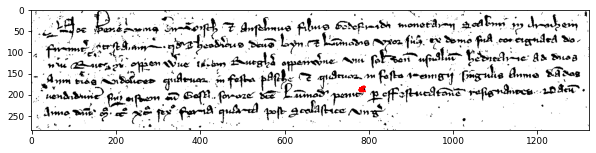

In [27]:
from random import randint, choice
def draw_image_with_surrounding_pixels(binary_image, key_point, points):
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_image, cmap="gray")
    print(points)
    for point in points:
        x_values = [key_point[1], point[1]]
        y_values = [key_point[0], point[0]]
        plt.plot(x_values, y_values, color='red')
    plt.show()
# choose random keypoint

point = tuple(choice(keypoints))
print(point)
draw_image_with_surrounding_pixels(closed, point, surrounding_points[point])

# Let's start pipelining the whole image processing part


In [ ]:
import os
# get all the folders in the dataset except the ones that start with a dot
folders_list = sorted([folder for folder in os.listdir('Download') if not folder.startswith('.')])
# assign a period to each folder
periods = {1300+idx*25: folder for idx, folder in enumerate(folders_list)}
print(periods)

{1300: 'MPS1300-ppm', 1325: 'MPS1325-ppm', 1350: 'MPS1350-ppm', 1375: 'MPS1375-ppm', 1400: 'MPS1400-ppm', 1425: 'MPS1425-ppm', 1450: 'MPS1450-ppm', 1475: 'MPS1475-ppm', 1500: 'MPS1500-ppm', 1525: 'MPS1525-ppm', 1550: 'MPS1550-ppm'}


In [20]:
'''def get_images(period):
    """returns a list of image paths for a given period"""
    folder = periods[period]
    folder_size = len(os.listdir(f'Download/{folder}'))
    # create an array to hold each path along with its label(period)
    image_paths = np.zeros((folder_size, 2), dtype=object)
    index = 0
    for file in os.listdir(f'Download/{folder}'):
        image_paths[index, 0] = f'Download/{folder}/{file}'
        image_paths[index, 1] = period
        index += 1
    return image_paths

def get_dataset_size():
    """returns the number of images in the dataset"""
    count = 0
    for period in periods:
        count += len(os.listdir(f'Download/{periods[period]}'))
    return count

'''

In [ ]:
from sklearn.model_selection import train_test_split

for period in periods:
    dataset = get_images(period)
    x_train, y_train, x_test, y_test = train_test_split(dataset[:, 0], dataset[:, 1], test_size=0.2)
    # store x_train under the directory of train
    np.save(f'train/paths/{period}', x_train, allow_pickle=True)
    # store x_train under the directory of test
    np.save(f'test/paths/{period}', x_test, allow_pickle=True)


In [ ]:
'''def display_image(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap="gray")
    plt.show()

def load_image_binarize(image_path):
    """loads an image from a given path"""
    # Load the image
    image = io.imread(image_path)
    image = color.rgb2gray(image)
    # Apply Sauvola thresholding
    window_size = 25
    thresh_sauvola = threshold_sauvola(image, window_size=window_size)
    binary_sauvola = image > thresh_sauvola
    return binary_sauvola
'''

In [ ]:
'''def get_forkpoints(skeleton):
    selems = list()
    selems.append(np.array([[0, 1, 0], [1, 1, 1], [0, 0, 0]]))
    selems.append(np.array([[1, 0, 1], [0, 1, 0], [1, 0, 0]]))
    selems.append(np.array([[1, 0, 1], [0, 1, 0], [0, 1, 0]]))
    selems.append(np.array([[0, 1, 0], [1, 1, 0], [0, 0, 1]]))
    selems.append(np.array([[0, 0, 1], [1, 1, 1], [0, 1, 0]]))
    selems = [np.rot90(selems[i], k=j) for i in range(5) for j in range(4)]

    selems.append(np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]]))
    selems.append(np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]]))

    forkpoints = np.zeros_like(skeleton, dtype=bool)
    for selem in selems:
        forkpoints |= ndi.binary_hit_or_miss(skeleton, selem)
    return np.argwhere(forkpoints)


def get_keypoints(skeleton):
    forkpoints = get_forkpoints(skeleton)
    open_cv_skeleton = skimage_to_opencv(skeleton)
    labels = opencv_connected_components(open_cv_skeleton)
    fragments = extract_fragments(skeleton, labels)
    e = 7
    high_curvature_points = extract_angles_minima(skeleton, fragments, e)
    keypoints = np.concatenate((forkpoints, np.array(high_curvature_points)))
    return keypoints

def get_psd(binary_image):
    skeleton = skeletonize(invert(binary_image))
    keypoints = get_keypoints(skeleton)
    keypoints_count = len(keypoints)
    num_directions = 120  # This should match the value you used in the `psd_feature_vector` function
    feature_vectors = np.zeros((keypoints_count, num_directions))
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(compute_feature_vector, [(binary_image, keypoint) for keypoint in keypoints]))

    for idx, result in enumerate(results):
        feature_vectors[idx] = result
    return feature_vectors
'''

AttributeError: 'NoneType' object has no attribute '__dict__'

In [ ]:
periods = [1300 + index * 25 for index in range(11)]
for period in periods:
    image_paths = np.load(f'train/paths/{period}.npy', allow_pickle=True)
    print(f'Loading images for period {period}...')
    binary_images = np.array(list(map(load_image_binarize, image_paths)), dtype=object)
    print(f'Computing features for period {period}...')
    features_of_period = np.array(list(map(get_psd, binary_images)), dtype=object)

    np.save(f'train/features/{period}', features_of_period, allow_pickle=True)

Loading images for period 1300...


/var/folders/zj/c7k3yqj15fq9cpjw00zcj9x80000gn/T/ipykernel_60529/2389276215.py:10: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = color.rgb2gray(image)


[(3, 1923), (5, 1943), (10, 113), (11, 1086), (12, 1087), (13, 1850), (15, 1788), (16, 1503), (17, 1819), (19, 1819), (23, 108), (24, 2924), (25, 2509), (25, 2923), (26, 2429), (26, 2486), (27, 2487), (28, 2349), (28, 2410), (29, 30), (32, 28), (32, 2966), (34, 1674), (34, 2738), (35, 1358), (35, 1673), (35, 2762), (35, 2842), (36, 1665), (37, 1695), (38, 1184), (38, 1696), (38, 1740), (38, 2856), (40, 1270), (40, 1742), (40, 2314), (41, 1766), (42, 82), (43, 82), (44, 82), (45, 83), (45, 348), (45, 433), (45, 2681), (46, 101), (46, 2680), (47, 2102), (47, 2177), (47, 2199), (48, 2200), (49, 2651), (50, 149), (50, 608), (50, 1647), (50, 2652), (51, 2540), (52, 151), (52, 2534), (53, 152), (53, 2538), (55, 153), (56, 153), (56, 2052), (56, 2065), (57, 2066), (58, 2067), (59, 1567), (60, 65), (60, 1775), (61, 67), (61, 832), (61, 882), (61, 894), (62, 1820), (63, 1887), (64, 1677), (64, 1987), (65, 694), (65, 1678), (65, 2966), (66, 1677), (67, 2732), (68, 2702), (69, 2703), (70, 957), (

KeyboardInterrupt: 